# Context Tree $\Phi$MDP

As per https://arxiv.org/pdf/1108.3614.pdf

I'm not sure how the Markovian property for context trees work?  In the paper a Markovian AOCT is given on page 12.  But if the history is ?0 -> 0 then action observation (21) is performed we end up on one of 3 states.  I'm therefore not sure what the definition of Markovian is for context trees.

Also the splitting / merging algorithm is quite complex.  A simpler algorithm might be to just mutate and check if it's valid, or... maybe even to just allow non MDP trees...

In [46]:
import numpy as np
import matplotlib.pyplot as plt
import kruskal
import gym

from maze import Maze_MDP, Maze_POMDP
from utilities import clip, smooth, int_to_bits, bits_to_int, softmax
from collections import deque
from gym import error, spaces, utils

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [47]:
# parameters for algorithm, taken from Nguyen's paper

ALPHA = 0.1
BETA = 0.1
INITIAL_SAMPLE_LENGTH = 5000
AGENT_LEARNING_LOOPS = 1
ITERATIONS = 100
I = 10
GAMMA = 0.999999 # ??? why is this so high?
ETA = 0.01


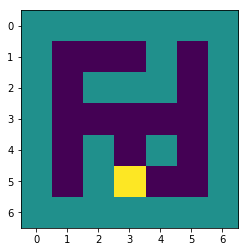

In [48]:
# create a maze for us to solve.
maze = Maze_POMDP(7,7)
maze.generate_random(4)
maze.plot()

## 1. Map Cost Function

We define a cost function for a given map based on how well it can predict future rewards as follows:

$$
Cost_{\alpha}(\Phi|h_n) := \alpha CL(s_{1:n}|a_{1:n})+(1-\alpha)CL(r_{1:n}|s_{1:n},a_{1:n})
$$


In [49]:
def entropy(p):
    """ Shannon entropy of a random variable with distribution p"""
    return np.sum(p * np.log2(p))

def code_length(history):
    """ returns code length of states given actions for given map.
        @param history Array of (state, action, reward) for every timestep.
    """
        
    States = set(s for s,a,r in history)
    Actions = set(a for s,a,r in history)
    Rewards = set(r for s,a,r in history)
    
    # make a history that is in the format s,a,r,s' where s' is the resulting state.
    _history = history
    history = []
    for i in range(len(_history)-1):        
        history.append((*_history[i], _history[i+1]))
    
    # code length for states given actions based on estimated frequencies
    state_code_length = 0
    for action in Actions:                    
        for state in States:
            state_action_counts = np.zeros(len(States))
            for s,a,r,s_prime in history:
                if s != state or a != action:
                    continue
                state_action_counts[s_prime] += 1
            state_action_sum = np.sum(state_action_counts)    
                
            state_code_length += state_action_sum * entropy(state_action_counts / state_action_sum)
            state_code_length += (len(States) - 1) / 2 * np.log2(state_action_sum)
            
    # code length for rewards given state and actions.
    reward_code_length
    for action in Actions:                    
        for state in States:
            for state_prime in States:
                state_reward_counts = np.zeros(len(Rewards))
                for s,a,r,s_prime in history:
                    if s != state or a != action or s_prime != state_prime:
                        continue
                    state_reward_counts[r] += 1
                state_reward_sum = np.sum(state_reward_counts)    
            
                reward_code_length = state_reward_sum * entropy(state_reward_counts / state_reward_sum)
                reward_code_length += (len(Rewards) - 1) / 2 * np.log2(state_reward_sum)

    return ALPHA * state_code_length + (1-ALPHA)*reward_code_length
            

## 2 Stochastic Search Algorithms

In [50]:
# Cost function.  Evaluate how good a map is given history.
# This should essentially be how well the MDP generated predicts rewards.

def map_cost(phi, history):
    """ Returns cost of using map phi, with supplied history. 
        @param phi a map...
        @param history Array of observational history (observation,action,reward)
    """
    history_with_states = [(phi(history[:n]), a, r) for n, (o,a,r) in enumerate(history)]
    return code_length(history_with_states)


### 2.1 Random Search

This is just a very simple search algoritm to get us up and running

In [51]:
class Node():
    def __init__(self, children):
        """ 
            param: children dictionary from edge to node
        """
        self.children = children                    
        
    def get_states(self):
        """ Returns list of all states this node  enables. """        
        result = []
        for edge, child in self.children.items():
            if child is None:
                result += [str(edge)]
            else:                    
                sub_states = child.get_states()  
                result += [str(edge)+'-'+state for state in sub_states]
        return result                    
    

class ContextTree():
        
    def __init__(self, root):
        self.root = root
            
    def encode(self, history):
        """ Maps from list of (observation) to state space. 
            @param history, (observation)
        """
        current = self.root
        
        states = []

        for o in reversed(history):
            if current is not None:
                current = current.children[o]
                states.append(o)
            else: 
                break
                
        return "-".join(str(x) for x in states)
    
    def is_markovian(self, Observations):
        """ Checks if this tree is Markovian or not."""
        for state in self.root.get_states():
            for observation in Observations:
                new_state 
        
class ActionContextTree():
    
    def __init__(self, root):
        self.root = root
    
    def encode(self, history):
        """ Maps from list of (observation) to state space. 
            @param history, (observation)
        """
        current = self.root
        
        states = []

        for (o,a,r) in reversed(history):
            if current is not None:
                current = current[o]
                states.append(o)
            else: 
                break
            if current is not None:
                current = current[a]
                states.append(a)
            else: 
                break
                                
        return "-".join(str(x) for x in states)
    
    
# these are the tests from Nyugen's paper

Left = Node({0:None, 1:None})
Right = Node({0:None, 1:None})
ct = ContextTree(Node({0:Left, 1:Right}))

print(ct.root.get_states())

ct = ContextTree(Node({0:None, 1:None}))
ct.root.children[1] = Node({0:None, 1:None})
ct.root.children[1].children[0] = Node({0:None, 1:None})

print(ct.root.get_states())
print(ct.encode([int(x) for x in "11101"]))
                            

['0-0', '0-1', '1-0', '1-1']
['0', '1-0-0', '1-0-1', '1-1']
1-0-1


In [ ]:
def random_search(h_initial, cost_function, iterations=1000):
    """ Peform a random search for a low cost map."""
    best_cost = float("inf")
    best_phi = None
    for i in range(iterations):
        # construct a random map
        phi = ...
        # evaluate it
        cost = cost_function(phi, h_initial)
        if cost < best_cost:
            best_phi = phi
            best_cost
    return phi
            
def random_context_tree(Observation, Action):
    """ Not a very good random context tree generator... but will probably do for testing.
        @param Observations observation space
        @param Action action space        
    """
    
    root = np.random.choose(Observation)
    
    
    


### 2.2 Parallel Temporing Algorithm

Perform parallel storechastic search over maps $\phi$

In [ ]:
#  todo..

## 3. $\Phi$ MDP Algorithm


In [15]:
# 1: Generate a history h^initial of length initialSampleNumber

obs = maze.reset()
h_initial = []
for i in range(INITIAL_SAMPLE_LENGTH):
    action = np.random.randint(len(maze.ACTIONS))
    obs, reward, done, info = maze.step(action)
    h_initial.append((obs, reward, action))
    
# 2: h←h^initial
h = h_initial.copy()

# 3: repeat
while True:
    
    #4: Run the chosen stochastic search scheme for the history h to find a Φˆ with low cost
    random_search(h_initial)
    
    #5: Compute MDP statistics (optimistic frequency estimates Rˆ and Tˆ) induced from Φˆ
    #6: Apply AVI to find the optimal Q^* values using the computed statistics Rˆ and Tˆ.
    #7: Interact with environment for additionalSampleNumber iterations of Q-Learning using Q^∗ as initial values; the obtained additional history is stored in h additional
    # 8: h←[h,hadditional]
    # 9: agentLearningLoops←agentLearningLoops−1
    # 10: until agentLearningLoops= 0
    # 11: Compute the optimal policy π optimal from the optimal Φ and Q values

